In [ ]:
import pandas as pd
import numpy as np|
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('META.csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
1,2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2,2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
3,2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
4,2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200
...,...,...,...,...,...,...,...
2946,2024-02-05,469.880005,471.899994,459.220001,459.410004,459.410004,40832400
2947,2024-02-06,464.000000,467.119995,453.000000,454.720001,454.720001,21655200
2948,2024-02-07,458.000000,471.519989,456.179993,469.589996,469.589996,23066000
2949,2024-02-08,468.320007,470.589996,465.029999,470.000000,470.000000,18815100


In [34]:
data = data[['Date', 'Close']]
data

,Date,Close
0,2012-05-18,38.230000
1,2012-05-21,34.029999
2,2012-05-22,31.000000
3,2012-05-23,32.000000
4,2012-05-24,33.029999
...,...,...
2946,2024-02-05,459.410004
2947,2024-02-06,454.720001
2948,2024-02-07,469.589996
2949,2024-02-08,470.000000


In [35]:
# Device agnostiv code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [36]:
data['Date'] = pd.to_datetime(data['Date'])
data['Date']

C:\Users\Kumud Jain\AppData\Local\Temp\ipykernel_3308\469103719.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


0      2012-05-18
1      2012-05-21
2      2012-05-22
3      2012-05-23
4      2012-05-24
          ...    
2946   2024-02-05
2947   2024-02-06
2948   2024-02-07
2949   2024-02-08
2950   2024-02-09
Name: Date, Length: 2951, dtype: datetime64[ns]

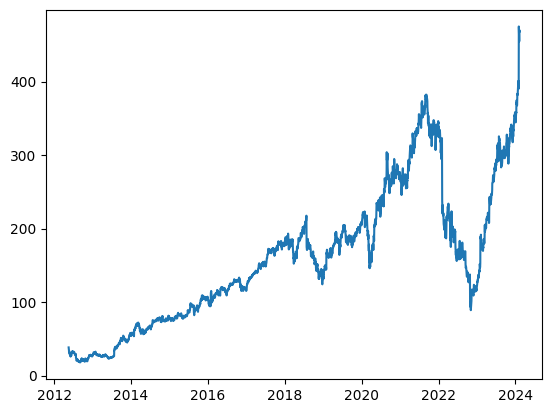

In [37]:
plt.plot(data['Date'], data['Close'])

In [38]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df = shifted_df[:180]
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2012-05-30,28.190001,28.840000,31.910000,33.029999,32.000000,31.000000,34.029999,38.230000
2012-05-31,29.600000,28.190001,28.840000,31.910000,33.029999,32.000000,31.000000,34.029999
2012-06-01,27.719999,29.600000,28.190001,28.840000,31.910000,33.029999,32.000000,31.000000
2012-06-04,26.900000,27.719999,29.600000,28.190001,28.840000,31.910000,33.029999,32.000000
2012-06-05,25.870001,26.900000,27.719999,29.600000,28.190001,28.840000,31.910000,33.029999
...,...,...,...,...,...,...,...,...
2013-02-11,28.260000,28.549999,28.650000,29.049999,28.639999,28.110001,29.730000,30.980000
2013-02-12,27.370001,28.260000,28.549999,28.650000,29.049999,28.639999,28.110001,29.730000
2013-02-13,27.910000,27.370001,28.260000,28.549999,28.650000,29.049999,28.639999,28.110001


In [39]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[28.190001, 28.84    , 31.91    , ..., 31.      , 34.029999,
        38.23    ],
       [29.6     , 28.190001, 28.84    , ..., 32.      , 31.      ,
        34.029999],
       [27.719999, 29.6     , 28.190001, ..., 33.029999, 32.      ,
        31.      ],
       ...,
       [27.91    , 27.370001, 28.26    , ..., 29.049999, 28.639999,
        28.110001],
       [28.5     , 27.91    , 27.370001, ..., 28.65    , 29.049999,
        28.639999],
       [28.32    , 28.5     , 27.91    , ..., 28.549999, 28.65    ,
        29.049999]])

In [40]:
shifted_df_as_np.shape

(180, 8)

In [41]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[0.36109335, 0.44567358, 0.84515314, ..., 0.72674063, 1.        ,
        1.        ],
       [0.54456754, 0.36109335, 0.44567358, ..., 0.85686426, 0.62822096,
        0.5902438 ],
       [0.29993498, 0.54456754, 0.36109335, ..., 0.99089148, 0.75092035,
        0.29463415],
       ...,
       [0.3246586 , 0.25439197, 0.37020187, ..., 0.47299941, 0.33865027,
        0.01268302],
       [0.40143154, 0.3246586 , 0.25439197, ..., 0.42095009, 0.38895702,
        0.06439015],
       [0.37800929, 0.40143154, 0.3246586 , ..., 0.40793759, 0.33987738,
        0.10439015]])

In [42]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((180, 7), (180,))

In [43]:
X = dc(np.flip(X, axis=1))
X

array([[1.        , 1.        , 0.72674063, ..., 0.99089148, 0.84515314,
        0.44567358],
       [0.5902438 , 0.62822096, 0.85686426, ..., 0.84515314, 0.44567358,
        0.36109335],
       [0.29463415, 0.75092035, 0.99089148, ..., 0.44567358, 0.36109335,
        0.54456754],
       ...,
       [0.01268302, 0.33865027, 0.47299941, ..., 0.40793759, 0.37020187,
        0.25439197],
       [0.06439015, 0.38895702, 0.42095009, ..., 0.37020187, 0.25439197,
        0.3246586 ],
       [0.10439015, 0.33987738, 0.40793759, ..., 0.25439197, 0.3246586 ,
        0.40143154]])

In [44]:
split_index = int(len(X) * 0.80)
split_index

144

In [45]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((144, 7), (36, 7), (144,), (36,))

In [46]:
# LSTM require extra dimension
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((144, 7, 1), (36, 7, 1), (144, 1), (36, 1))

In [47]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([144, 7, 1]),
 torch.Size([36, 7, 1]),
 torch.Size([144, 1]),
 torch.Size([36, 1]))

In [48]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [49]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [50]:

for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [51]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [69]:
def train_one_epoch():
    model.train(True)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            running_loss = 0.0
    return running_loss / len(train_loader), model, loss_function

In [66]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    return running_loss/len(test_loader)

In [54]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() 
  acc = (correct/len(y_pred)) * 100
  return acc

In [55]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.265
***************************************************

Epoch: 2

Val Loss: 0.261
***************************************************

Epoch: 3

Val Loss: 0.250
***************************************************

Epoch: 4

Val Loss: 0.239
***************************************************

Epoch: 5

Val Loss: 0.226
***************************************************

Epoch: 6

Val Loss: 0.210
***************************************************

Epoch: 7

Val Loss: 0.194
***************************************************

Epoch: 8

Val Loss: 0.177
***************************************************

Epoch: 9

Val Loss: 0.159
***************************************************

Epoch: 10

Val Loss: 0.140
***************************************************



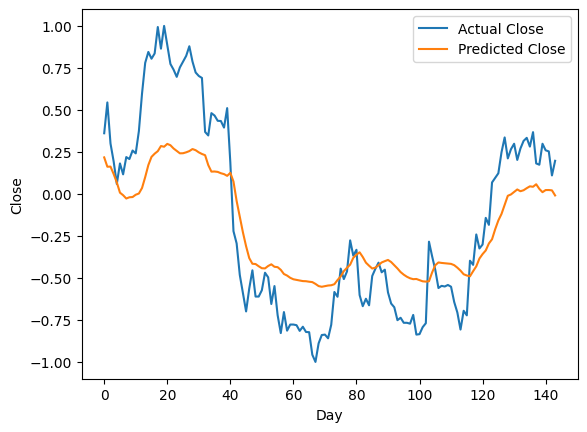

In [56]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [57]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([27.08605159, 26.6594904 , 26.66484857, 26.32464156, 25.94047975,
       25.47266613, 25.35595027, 25.20482584, 25.26163805, 25.27206482,
       25.37803858, 25.43382018, 25.6868564 , 26.18333149, 26.73483031,
       27.10885046, 27.25586958, 27.37201672, 27.6046834 , 27.573958  ,
       27.70343783, 27.64248173, 27.49381668, 27.38266734, 27.27197011,
       27.2761419 , 27.3181528 , 27.37396829, 27.46808805, 27.41458416,
       27.31618645, 27.24217617, 27.18690245, 26.73476069, 26.43527507,
       26.44071283, 26.42227493, 26.3620913 , 26.3215079 , 26.24159149,
       26.37902132, 25.9818371 , 25.09172143, 24.37979264, 23.65320337,
       23.02144236, 22.47908043, 22.22089491, 22.20779205, 22.10569561,
       22.01565215, 22.00778952, 22.11880992, 22.19527369, 22.08233813,
       22.06457496, 21.94290051, 21.75152373, 21.68046967, 21.57773377,
       21.51059751, 21.48059722, 21.45406721, 21.42762331, 21.42147933,
       21.39846723, 21.38148551, 21.29971189, 21.19928233, 21.16

In [58]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([28.19000097, 29.59999989, 27.71999905, 26.90000001, 25.87000101,
       26.80999903, 26.30999899, 27.10000003, 27.00999996, 27.39999994,
       27.26999998, 28.2900011 , 30.00999986, 31.41000021, 31.91000014,
       31.60000005, 31.84000007, 33.0499992 , 32.06000112, 33.099998  ,
       32.23000016, 31.36000095, 31.10000013, 30.77000016, 31.20000094,
       31.46999895, 31.72999978, 32.16999821, 31.46999895, 30.96999903,
       30.80999901, 30.71999906, 28.24999995, 28.08999994, 29.11000105,
       29.00000007, 28.76000005, 28.7500001 , 28.45000111, 29.33999998,
       26.84999995, 23.709999  , 23.1500001 , 21.70999907, 20.87999917,
       20.04000116, 21.08999982, 21.91999994, 20.71999916, 20.71999916,
       21.00999981, 21.80999896, 21.59999992, 20.37999879, 21.20000103,
       19.87000121, 19.04999896, 20.00999996, 19.16000017, 19.44000088,
       19.44000088, 19.41000014, 19.14999977, 19.34000008, 19.10000006,
       19.09000011, 18.05999905, 17.73      , 18.57999978, 18.95

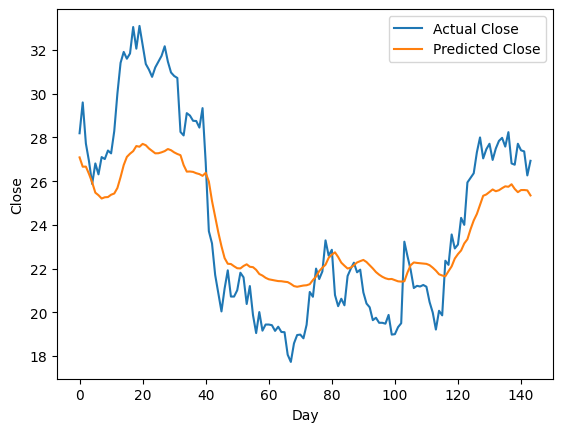

In [59]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [60]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([25.32289125, 25.24277407, 25.08900318, 24.94472441, 24.99822355,
       25.32890108, 25.51281368, 25.82043863, 26.1528535 , 26.28943889,
       26.65228211, 26.97139579, 27.20103399, 27.20146411, 27.0657645 ,
       26.95084703, 26.93698528, 26.83896982, 26.96255291, 27.04049885,
       27.1274433 , 27.25006457, 27.45330686, 27.30328606, 27.30394773,
       27.26038172, 27.03482885, 26.6227006 , 26.47009611, 26.44846587,
       26.36202798, 26.28288277, 26.17847787, 25.94753636, 25.91828735,
       26.01469364])

In [61]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([26.51000003, 26.04999902, 25.90999999, 26.62000102, 27.99999999,
       27.76999991, 28.76000005, 29.41999999, 29.05999904, 30.5899998 ,
       31.299999  , 31.71999892, 30.95000097, 30.09999981, 29.84999985,
       30.13999913, 29.66000001, 30.72999992, 30.81999987, 31.07999978,
       31.54000085, 32.4700011 , 30.79000096, 31.23999979, 30.97999989,
       29.73000007, 28.11000097, 28.63999889, 29.0499991 , 28.64999998,
       28.54999894, 28.25999989, 27.37000102, 27.91000004, 28.49999991,
       28.32000001])

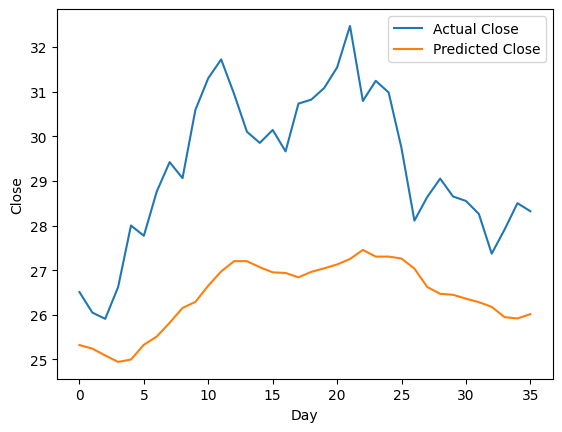

In [62]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [63]:
#Data
#Time
#Space
#Integration with Flask
#Report in Spread Sheet

# Evaluating under different condition.

# - Using : 6 Months Of Data

In [71]:
evaluation_periods = [6, 12, 24, 60, 84]  # in months
for period in evaluation_periods:
    # Get the corresponding DataLoader objects for training and testing data for this period
    
    # Train the model
    train_loss, train_time = train_one_epoch()
    
    # Validate the model
    val_loss = validate_one_epoch()
    
    # Record evaluation metrics
    print(f"Evaluation Period: {period} months")
    print(f"Training Loss: {train_loss}, Validation Loss: {val_loss}")
    print(f"Training Time: {train_time} seconds")
    print("***************************************************")


ValueError: too many values to unpack (expected 2)

In [ ]:
shifted_df = shifted_df[:180]